# Linear regression model on Spark

In this notebook, we use a standard linear regression model (as implemented in Spark) to classify our pre-processed dataset. Specifically, we test the performance of our model with four different sets of features; then, we run a cross-validation on the one yielding the best results, to further optimize the obtained results.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
inputPath = "/user/s291516/preprocessed/"
trainData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "trainData/")
testData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "testData/")

## Evaluators definition

In [3]:
rmseEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="rmse")
r2Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="r2")
resultsDF = pd.DataFrame(columns=["Features", "Metric", "Value"])

## Label mapper definition

For prediction purposes, we are going to use the "diff" version of the features as produced in the data preprocessing notebook. The `LabelMapper` transformer will be used to translate back the "diff" prediction to a full prediction, obtained by summing the obtained prediction to the value of the `NumBikes` attribute.

In [4]:
class LabelMapper(Transformer):
    def _transform(self, inputDF):
        return inputDF.withColumn("prediction", F.col("prediction") + F.col("NumBikes"))

## Solution #1: only numerical features

In our first solution, we use only the numerical features exposed by our dataset (`NumBikesDiff-3`, `NumBikesDiff-2`, `NumBikesDiff-1`, `NumBikesDiff` and `NumBikes`) to predict the value of `NumBikesDiff+1`.

In [5]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"], outputCol="features"),
    LinearRegression(labelCol="NumBikesDiff+1"),
    LabelMapper()
])

model = pipeline.fit(trainData)
print("Training RMSE:", model.stages[1].summary.rootMeanSquaredError)

Training RMSE: 1.2696778011746317


This model already presents some improvements over the baseline, as reflected in the following evaluation metrics.

In [6]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Only numerical", "Metric": "RMSE", "Value": rmse},
    {"Features": "Only numerical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4422666210457207
R2: 0.9663775220166556


## Solution #2: one-hot encoded categorical features

In the second solution, we enlarge the feature space by adding the one-hot encoded version of our categorical features (the hour, the day of the week, and the zone of the station) into the model.

In [7]:
pipeline = Pipeline(stages=[
    OneHotEncoder(inputCol="Hour", outputCol="HourOH"),
    OneHotEncoder(inputCol="DayOfWeek", outputCol="DayOfWeekOH"),
    OneHotEncoder(inputCol="Zone", outputCol="ZoneOH"),
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "HourOH", "DayOfWeekOH", "ZoneOH"
    ], outputCol="features"),
    LinearRegression(labelCol="NumBikesDiff+1"),
    LabelMapper()
])

model = pipeline.fit(trainData)
print("Training RMSE:", model.stages[4].summary.rootMeanSquaredError)

Training RMSE: 1.2660696244537368


The resulting model performs slightly better than the previous one, as shown by the metrics below.

In [8]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Categorical OH", "Metric": "RMSE", "Value": rmse},
    {"Features": "Categorical OH", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4386726782819135
R2: 0.9665448790146446


## Solution #3: disjoint, effect-encoded categorical features

In the third solution, we use the effect-encoded version of our categorical features, considering only the "disjoint" ones (i.e., we consider separately the effect of the hour, day of the week, and zone of the station).

In [9]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "AvgByHour", "AvgByWeekday", "AvgByZone"
    ], outputCol="features"),
    LinearRegression(labelCol="NumBikesDiff+1"),
    LabelMapper()
])

model = pipeline.fit(trainData)
print("Training RMSE:", model.stages[1].summary.rootMeanSquaredError)

Training RMSE: 1.2674470380187084


The resulting model performs somewhere in between the first and second solution.

In [10]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Disjoint effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Disjoint effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.440439513318856
R2: 0.9664626560362883


## Solution #4: combined, effect-encoded categorical features

Here, we consider a solution in which we use all the available numerical features, plus the joint average computed considering all the categorical values at once.

In [11]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"], outputCol="features"),
    LinearRegression(labelCol="NumBikesDiff+1"),
    LabelMapper()
])

model = pipeline.fit(trainData)
print("Training RMSE:", model.stages[1].summary.rootMeanSquaredError)

Training RMSE: 1.2570201799143175


This solution improves quite a bit over the previous models, presenting the lowest observed RMSE and highest R2 coefficient.

In [12]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Combined effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Combined effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4337551592291111
R2: 0.9667731936707784


## Solution #5: putting all together

Finally, we test a solution in which all the aforementioned features are fed to the regression algorithm.

In [13]:
pipeline = Pipeline(stages=[
    OneHotEncoder(inputCol="Hour", outputCol="HourOH"),
    OneHotEncoder(inputCol="DayOfWeek", outputCol="DayOfWeekOH"),
    OneHotEncoder(inputCol="Zone", outputCol="ZoneOH"),
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "HourOH", "DayOfWeekOH", "ZoneOH",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    LinearRegression(labelCol="NumBikesDiff+1"),
    LabelMapper()
])

model = pipeline.fit(trainData)
print("Training RMSE:", model.stages[4].summary.rootMeanSquaredError)

Training RMSE: 1.255196096644463


With respect to the previous case, we observe a slight improvement of the reference metrics, although this might not be enough to justify the usage of a largely more complex model (we remind that here, due to the usage of one-hot encoded categorical variables, we are regressing on a significantly larger set of features).

In [14]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All", "Metric": "RMSE", "Value": rmse},
    {"Features": "All", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4316515430100976
R2: 0.9668706233775958


## Hyperparameter optimization

For solution #4, we run an optimization procedure to determine the best value for the parameters of the regression model, so to increase even further the performance of our model. To do so, we used the parameter grid defined in the cell below, in which we tested different values of all the parameters of Spark's linear regression model; then, we fitted a `Pipeline` object using a `CrossValidator` stage (the number of CV folds was set to its default value of 3).

In [15]:
lr = LinearRegression()
grid = ParamGridBuilder() \
    .baseOn({lr.labelCol: "NumBikesDiff+1"}) \
    .addGrid(lr.maxIter, [100, 500, 1000]) \
    .addGrid(lr.regParam, [0.0, 0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1]) \
    .build()

In [16]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"], outputCol="features"),
    CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=rmseEvaluator)
])

model = pipeline.fit(trainData)
print("Training RMSE:", model.stages[1].bestModel.summary.rootMeanSquaredError)

Training RMSE: 1.2703915155281909


The overall best model is characterized by the parameters below.

In [17]:
print("Best model params:")
print("\n".join([f"- {x[0].name}: {x[1]}" for x in model.stages[1].bestModel.extractParamMap().items()]))

Best model params:
- aggregationDepth: 2
- elasticNetParam: 1.0
- epsilon: 1.35
- featuresCol: features
- fitIntercept: True
- labelCol: NumBikesDiff+1
- loss: squaredError
- maxIter: 100
- predictionCol: prediction
- regParam: 0.1
- solver: auto
- standardization: True
- tol: 1e-06


Finally, we apply the optimized model on our test data. We observe that the performance of this model on our test data is worse than the previous case: this is probably a case of overfitting, in which we have a model that fits too precisely our training/validation data and is not capable of generalizing properly on test data.

In [18]:
predictedTestData = LabelMapper().transform(model.transform(testData))

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Combined effect (CV)", "Metric": "RMSE", "Value": rmse},
    {"Features": "Combined effect (CV)", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4464266930730674
R2: 0.966183281019444


## Comparison of the results

The two graphs below summarize the evolution of the RMSE and R2 metrics for the different sets of features tested.

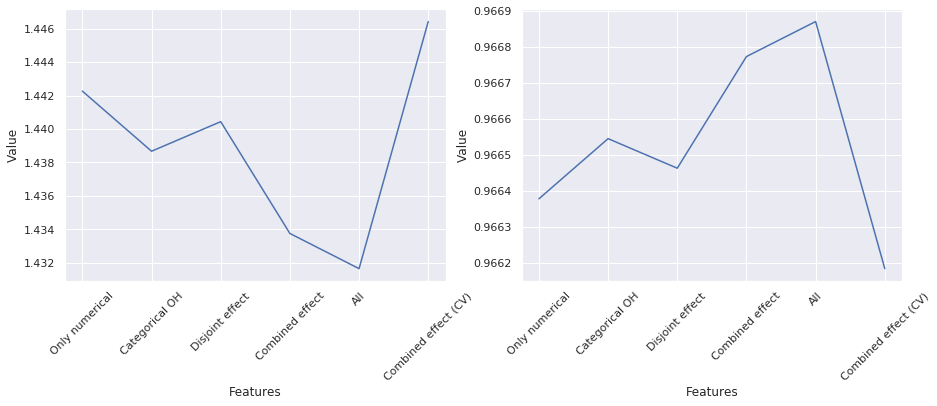

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "RMSE"], x="Features", y="Value", ax=ax[0])
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "R2"], x="Features", y="Value", ax=ax[1])
ax[0].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "RMSE"]["Features"], rotation=45)
ax[1].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "R2"]["Features"], rotation=45);